# 311 NYC Service Request Analysis and Time Series Forecasting

## Yes! I do love New York! 

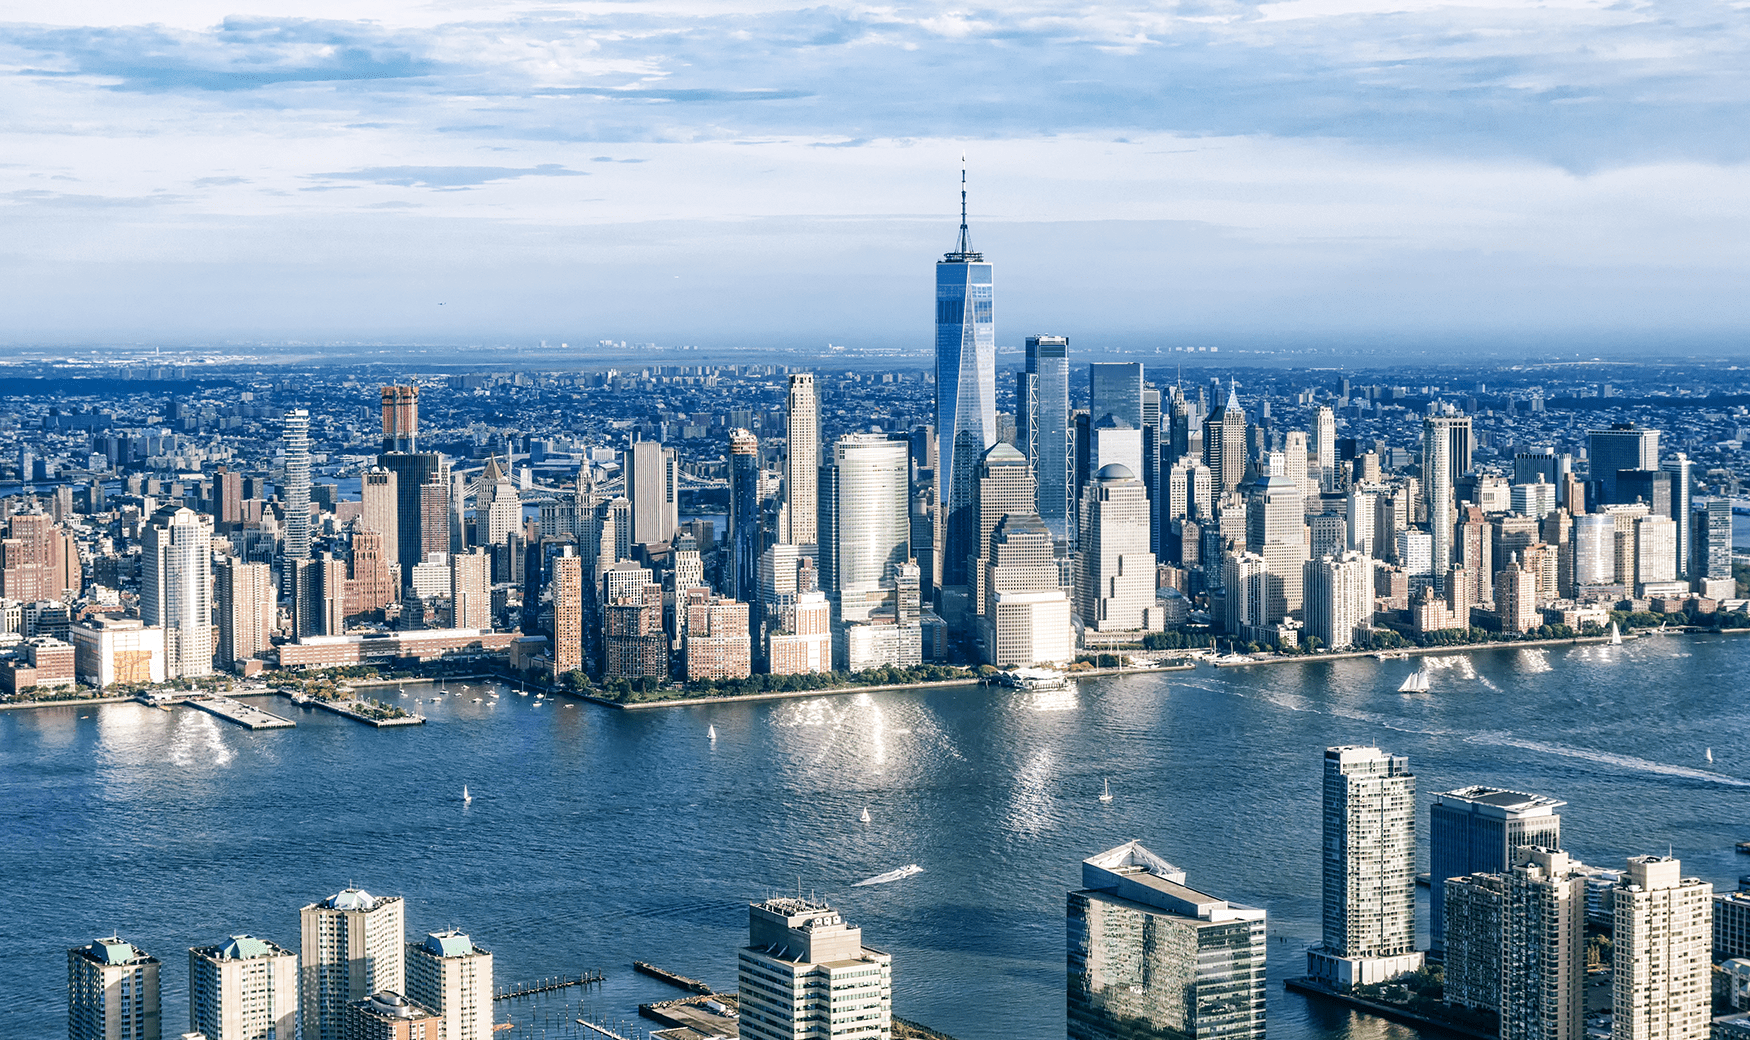

In [56]:
from IPython import display
display.Image("Location-NewYork.png")

## Importing libraries required for Analysis

In [1]:
#--------------------------------------------
# Importing Analysis libraries
#--------------------------------------------
import pandas as pd
import dask.dataframe as dd
import numpy as np
import os
import warnings
warnings.filterwarnings(action='ignore')
from datetime import datetime
import requests
import calendar
from pandas.tseries.offsets import DateOffset

#-----------------------------------------------------------
# Importing Statistical libraries
#-----------------------------------------------------------
import scipy.stats as ss 
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import grangercausalitytests

#------------------------------------------------------------------------------
# Importing Evaluation metrics libraries
#------------------------------------------------------------------------------
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

#--------------------------------------------------
# Importing Time Series Forecasting libraries
#--------------------------------------------------
# For ARIMA Model
#--------------------------------------------------
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.api import qqplot
import statsmodels.tsa.api as tsa
import statsmodels.api as sm
from pmdarima.arima import auto_arima

#--------------------------
# For Prophet Model
#--------------------------
from prophet import Prophet
#--------------------------

#----------------------------------
# Importing Visualisation libraries
#----------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode()

In [2]:
#-----------------------------------------------------------------------------
# Importing 311 NYC Service Request data as CSV
#-----------------------------------------------------------------------------
nycservice = pd.read_csv('Source Dataset files/311_data.csv')

nycservice.head()

unique_key             created_date agency complaint_type  \
0    32310161  2016-01-01T00:00:00.000  DOHMH         Rodent   
1    32310287  2016-01-01T00:00:00.000  DOHMH         Rodent   
2    32310788  2016-01-01T00:00:00.000  DOHMH         Rodent   
3    32310789  2016-01-01T00:00:00.000  DOHMH         Rodent   
4    32310790  2016-01-01T00:00:00.000  DOHMH         Rodent   

             location_type incident_zip    borough  
0               Vacant Lot        10473      BRONX  
1    Other (Explain Below)        10468      BRONX  
2  3+ Family Apt. Building        10029  MANHATTAN  
3  3+ Family Apt. Building        11432     QUEENS  
4  3+ Family Apt. Building        11210   BROOKLYN

## Performing EDA (Exploratory Data Analysis)

In [3]:
#---------------------------------------------------------------
# Performing a Pandas Profiling on the data
# Please View the HTML file attached to understand the data..
#---------------------------------------------------------------
from pandas_profiling import ProfileReport


profile = ProfileReport(nycservice, title="Pandas Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
#---------------------------------------
# Importing the weather datasets as CSVs
#---------------------------------------
weather_desc = pd.read_csv('weather_description.csv')
cityatt = pd.read_csv('city_attributes.csv')
humid = pd.read_csv('humidity.csv')
pressure = pd.read_csv('pressure.csv')
temperature = pd.read_csv('temperature.csv')
winddir = pd.read_csv('wind_direction.csv')
windspeed = pd.read_csv('wind_speed.csv')

In [5]:
#-------------------------------------------------
# Checking for Null Values in the 311 service data
#-------------------------------------------------
nycservice.isna().sum()

unique_key             0
created_date           0
agency                 0
complaint_type         0
location_type     563548
incident_zip      133193
borough                0
dtype: int64

In [6]:
#----------------------------------------------------------
# Getting some information about the dataframe using info()
#----------------------------------------------------------
nycservice.info()
print('-----------------------------------------------------------------------------------')
print('Number of rows and columns in the data as (RowCount,ColumnCount):',nycservice.shape)
print('-----------------------------------------------------------------------------------')
nycservice['created_date'] = dd.to_datetime(nycservice['created_date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2391388 entries, 0 to 2391387
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   unique_key      int64 
 1   created_date    object
 2   agency          object
 3   complaint_type  object
 4   location_type   object
 5   incident_zip    object
 6   borough         object
dtypes: int64(1), object(6)
memory usage: 127.7+ MB
-----------------------------------------------------------------------------------
Number of rows and columns in the data as (RowCount,ColumnCount): (2391388, 7)
-----------------------------------------------------------------------------------


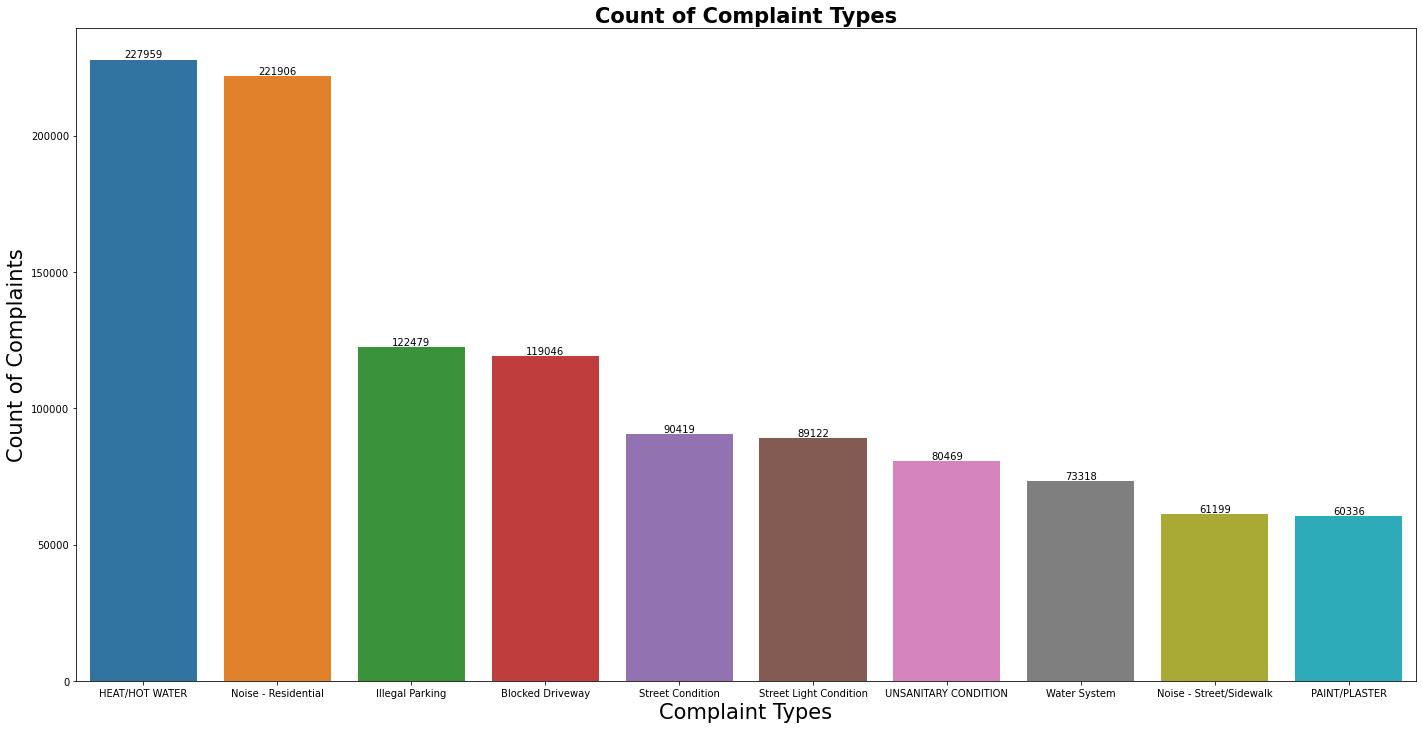

In [7]:
#------------------------------------------
# Visualising the data for gaining insights
#------------------------------------------
plt.gcf().set_size_inches(24, 12)
ax = sns.countplot(x="complaint_type", data=nycservice, order=pd.value_counts(
    nycservice['complaint_type']).iloc[:10].index)
ax.set_title('Count of Complaint Types', fontsize=21, fontweight='bold', color='black')
ax.set_xlabel('Complaint Types', fontsize=21, color='black')
ax.set_ylabel('Count of Complaints', fontsize=21, color='black')
for container in ax.containers:
    ax.bar_label(container)
#------------------------------------------------------
# TOTAL COMPLAINTS RECEIVED BY COMPLAINT TYPES
# Heat/hot water complaint was the most received at 311
#------------------------------------------------------

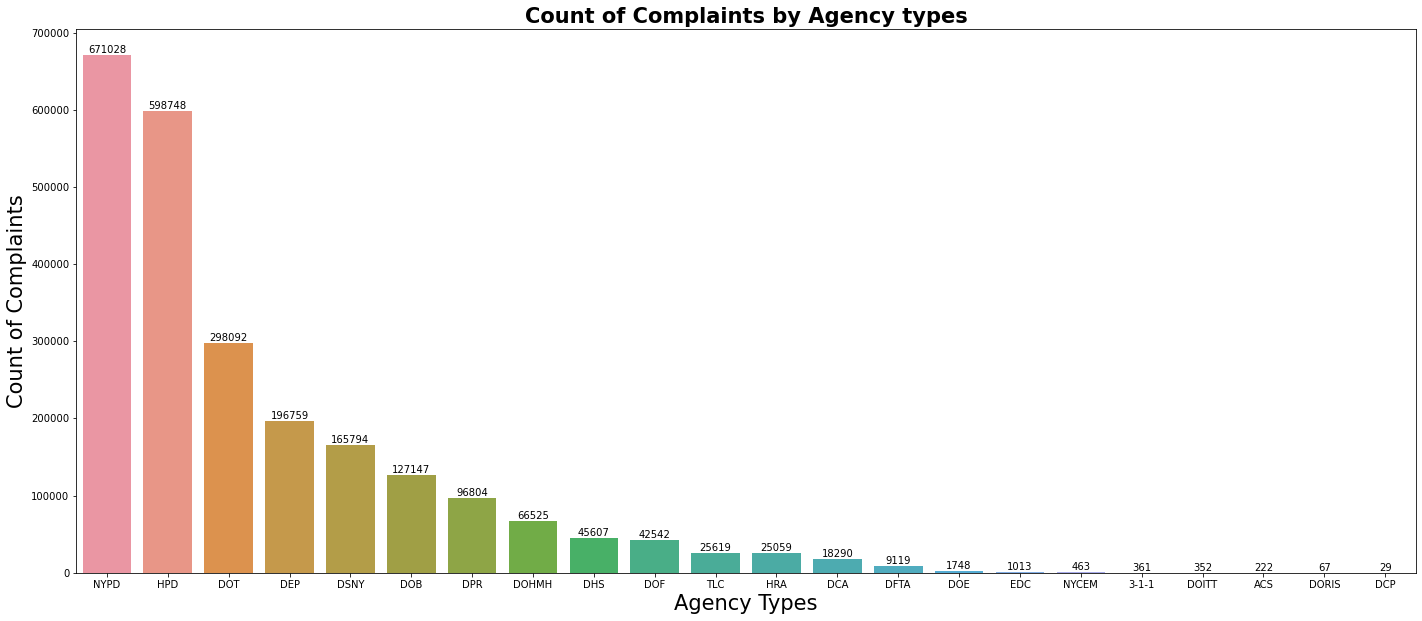

In [8]:
plt.gcf().set_size_inches(24, 10)
ax1 = sns.countplot(x="agency", data=nycservice, order=pd.value_counts(nycservice['agency']).index)
ax1.set_title('Count of Complaints by Agency types', fontsize=21, fontweight='bold', color='black')
ax1.set_xlabel('Agency Types', fontsize=21, color='black')
ax1.set_ylabel('Count of Complaints', fontsize=21, color='black')
for container in ax1.containers:
    ax1.bar_label(container)
#----------------------------------------------    
# New York Police Department got the most calls
#----------------------------------------------

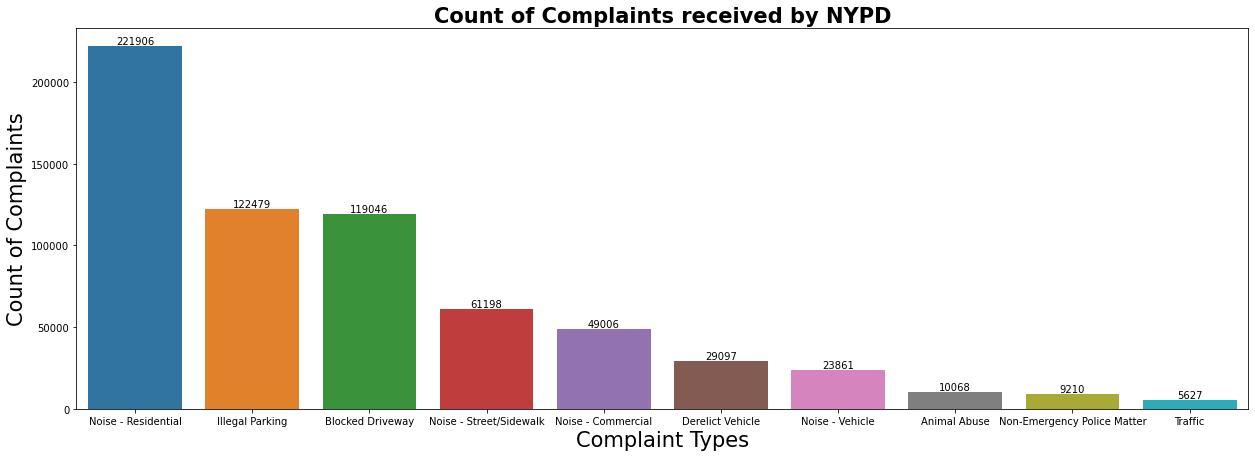

In [9]:
#---------------------------------------------------------------------------------------------
# Let us see NYPD's complaint types
#---------------------------------------------------------------------------------------------
nypdcomplaint = nycservice[nycservice['agency']=='NYPD']
plt.gcf().set_size_inches(21, 7)
ax2 = sns.countplot(x="complaint_type", data=nypdcomplaint, order=pd.value_counts(
    nypdcomplaint['complaint_type']).head(n=10).index)
ax2.set_title('Count of Complaints received by NYPD', fontsize=21, fontweight='bold', color='black')
ax2.set_xlabel('Complaint Types', fontsize=21, color='black')
ax2.set_ylabel('Count of Complaints', fontsize=21, color='black')
for container in ax2.containers:
    ax2.bar_label(container)
#---------------------------------------------------------------------------------------------
# The below chart shows us that the top complaint type received by NYPD is Noise - Residential
#---------------------------------------------------------------------------------------------

The Borough names are:  ['BRONX' 'BROOKLYN' 'MANHATTAN' 'QUEENS' 'STATEN ISLAND']
Enter the name of the Borough to view the call count: BROOKLYN


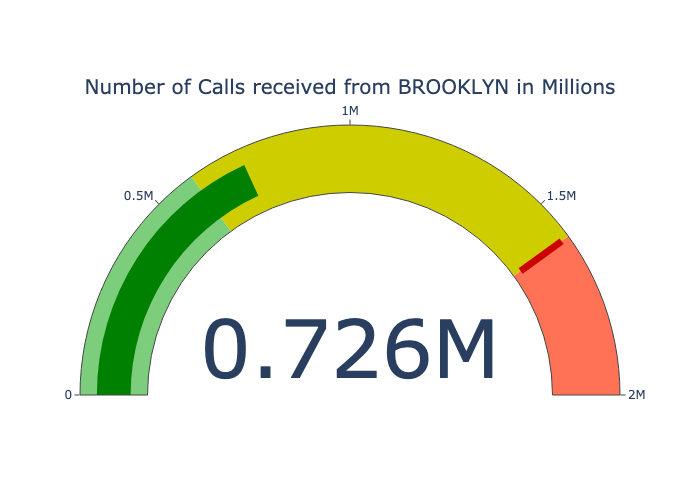

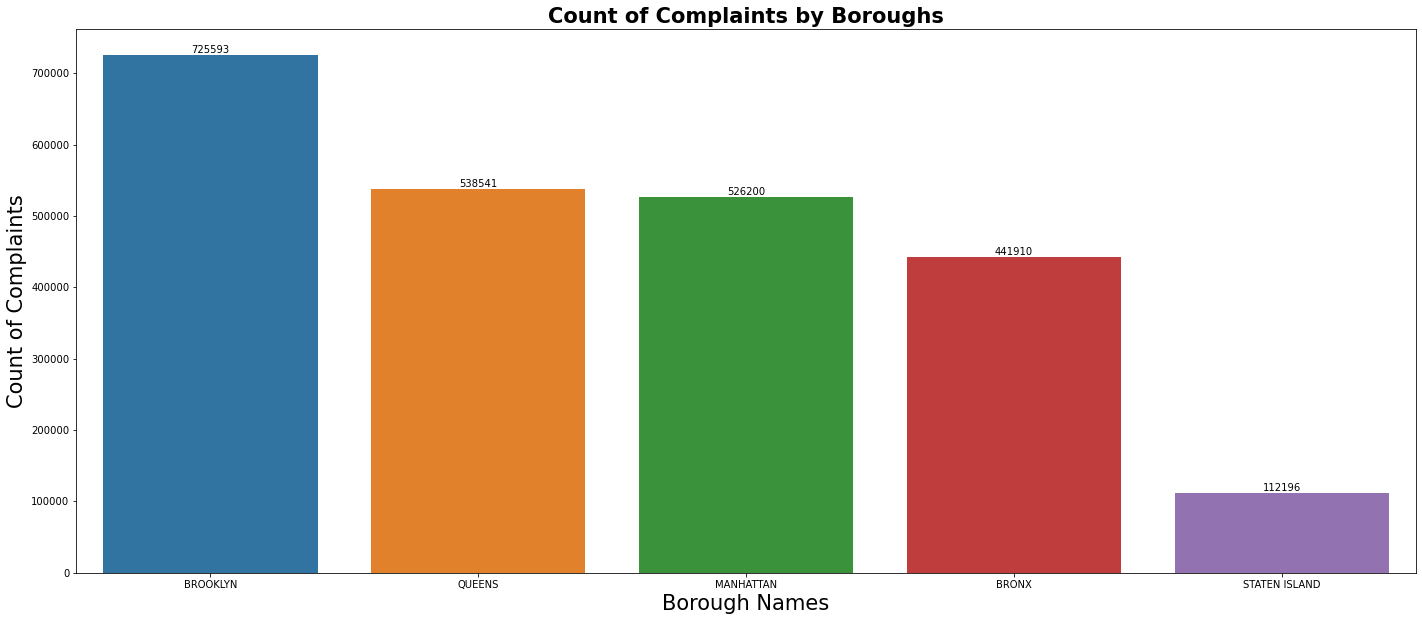

In [10]:
plt.gcf().set_size_inches(24, 10)
nycborough = nycservice[nycservice['borough'] != 'Unspecified']
nycborough
ax4 = sns.countplot(x="borough", data=nycborough, order=pd.value_counts(nycborough['borough']).index)
ax4.set_title('Count of Complaints by Boroughs', fontsize=21, fontweight='bold', color='black')
ax4.set_xlabel('Borough Names', fontsize=21, color='black')
ax4.set_ylabel('Count of Complaints', fontsize=21, color='black')
for container in ax4.containers:
    ax4.bar_label(container)
boroughcount = nycborough.groupby('borough')['unique_key'].count().to_frame().reset_index().rename(
    {'unique_key':'Count'}, axis=1)

print('The Borough names are: ', boroughcount['borough'].values)
boroughname = input('Enter the name of the Borough to view the call count: ')

def boroughcomplaints(boroughname):
    boroughlist = list(boroughcount['borough'])
    complaintcount = list(boroughcount['Count'])
    n=max(complaintcount)
    countval = float(boroughcount['Count'][(boroughcount['borough']== boroughname)].values)
    fig = go.Figure(go.Indicator(
        domain = {'x': [0, 1], 'y': [0, 1]},
        value = countval,
        mode = "gauge+number",
        title = {'text': f"Number of Calls received from {boroughname} in Millions"},
        gauge = {'axis': {'range': [None, 2000000]},'steps' : [{'range': [0, 600000], 'color': "#7CCD7C"},{
            'range':[600000, 1600000], 'color': "#CDCD00"},{'range': [1600000,2000000 ], 'color': "#FF7256"}],'threshold' : {'line': {'color': "#CD0000", 'width': 7}, 'thickness': 0.75, 'value': 1600000}}))
    pyo.iplot(fig)
    fig.show('png')

try:
    boroughcomplaints(boroughname)
except:
    print('Please select the BOROUGHS Available from the List')

#-----------------------------------------------------------------------------------------------------
# Let us see each Borough's complaint count in the year 2016 (in Millions)
# Please enter a valid Input from the list to view the count of complaints from the particular Borough
#-----------------------------------------------------------------------------------------------------

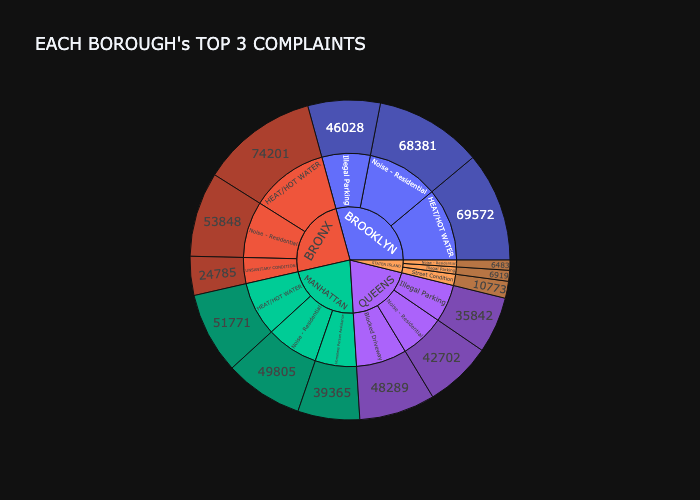

In [11]:
#-----------------------------------------------------------------------------------------------------
#From the previous Gauge Chart, we can infer that BROOKLYN borough produced more calls (0.726 million)
#Let us check what complaint type has been more in Brooklyn as focus
#-----------------------------------------------------------------------------------------------------
a = nycborough.groupby(['borough', 'complaint_type'])['unique_key'].agg('count').groupby(level=0).nlargest(3).to_frame().reset_index(
    drop=True,level=1).reset_index().rename({'unique_key':'Count_Of_Complaints',
                                             'borough':'Borough_Name','complaint_type':'Type_Of_Complaint'}, axis=1)

fig = px.sunburst(a, path=['Borough_Name', 'Type_Of_Complaint', 'Count_Of_Complaints'], 
                  values='Count_Of_Complaints', template='plotly_dark', title="EACH BOROUGH's TOP 3 COMPLAINTS")

pyo.iplot(fig)

fig.show('png')
#---------------------------------------------------------------------
# THE BELOW CHART DEPICTS EACH BOROUGH's TOP 3 REPORTED COMPLAINTS
# FOCUSING ON BROOKLYN HEAT/HOT WATER HAS BEEN THE PROBLEM IN BROOKLYN
#---------------------------------------------------------------------

In [12]:
#--------------------------------------------------------------------------------------------
# Extracting only the Date, Month and Year from the created_date column available as Timestamp
#--------------------------------------------------------------------------------------------
nycservice['DateOnly'] = nycservice['created_date'].apply(lambda x: x.date())
nycservice

unique_key        created_date agency       complaint_type  \
0          32310161 2016-01-01 00:00:00  DOHMH               Rodent   
1          32310287 2016-01-01 00:00:00  DOHMH               Rodent   
2          32310788 2016-01-01 00:00:00  DOHMH               Rodent   
3          32310789 2016-01-01 00:00:00  DOHMH               Rodent   
4          32310790 2016-01-01 00:00:00  DOHMH               Rodent   
...             ...                 ...    ...                  ...   
2391383    35137497 2016-12-31 23:58:26   NYPD     Derelict Vehicle   
2391384    35142668 2016-12-31 23:58:52   NYPD  Noise - Residential   
2391385    35143535 2016-12-31 23:59:02    HPD       HEAT/HOT WATER   
2391386    35138369 2016-12-31 23:59:21   NYPD     Blocked Driveway   
2391387    35140259 2016-12-31 23:59:31   NYPD      Illegal Parking   

                      location_type incident_zip    borough    DateOnly  
0                        Vacant Lot        10473      BRONX  2016-01-01  
1             Other (Explain Below)        10468      BRONX  2016-01-01  
2           3+ Family Apt. Building        10029  MANHATTAN  2016-01-01  
3           3+ Family Apt. Building        11432     QUEENS  2016-01-01  
4           3+ Family Apt. Building        11210   BROOKLYN  2016-01-01  
...                             ...          ...        ...         ...  
2391383             Street/Sidewalk      10009.0  MANHATTAN  2016-12-31  
2391384  Residential Building/House      10463.0      BRONX  2016-12-31  
2391385        RESIDENTIAL BUILDING      11225.0   BROOKLYN  2016-12-31  
2391386             Street/Sidewalk      11213.0   BROOKLYN  2016-12-31  
2391387             Street/Sidewalk      11230.0   BROOKLYN  2016-12-31  

[2391388 rows x 8 columns]

In [13]:
count = nycservice.groupby('DateOnly')['unique_key'].count().to_frame().reset_index().rename(
    {'unique_key':'Count_of_calls_each_day'}, axis=1).sort_values(
    by='Count_of_calls_each_day', ascending=False).reset_index(drop=True)
count
#---------------------------------------------------------------------------
# We can see the number of calls received by 311 for the entire year of 2016
#---------------------------------------------------------------------------

DateOnly  Count_of_calls_each_day
0    2016-01-05                    12035
1    2016-01-19                    10376
2    2016-02-14                     9920
3    2016-12-16                     9659
4    2016-11-21                     9484
..          ...                      ...
361  2016-12-26                     4172
362  2016-11-24                     4049
363  2016-12-24                     3974
364  2016-12-25                     3584
365  2016-11-06                     3412

[366 rows x 2 columns]

In [14]:
nytemperature = temperature.iloc[:,[0,28]]
nytemperature['datetime'] = nytemperature['datetime'].apply(
    lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date())

nytemperature['New York'] = nytemperature['New York'].apply(lambda x:x-273.15)

#---------------Converted the Temperature from Kelvin to Celsius---------------

nytemperature = nytemperature.rename({'New York':'NY_Celsius'}, axis=1).dropna()
nytemperature = nytemperature.groupby('datetime')['NY_Celsius'].agg('mean').round().to_frame().reset_index()
nytemperature
#-----------------------------------------------------------------------------------------------------------------
# Considering only New York & converting the New York temperatures from Kelvin to Celsius for better understanding
# We have the Temperature (in Celsius) data from 2012-2017
#-----------------------------------------------------------------------------------------------------------------

datetime  NY_Celsius
0     2012-10-01        15.0
1     2012-10-02        18.0
2     2012-10-03        17.0
3     2012-10-04        19.0
4     2012-10-05        21.0
...          ...         ...
1849  2017-10-24        21.0
1850  2017-10-25        17.0
1851  2017-10-26        13.0
1852  2017-10-27        11.0
1853  2017-10-28        12.0

[1854 rows x 2 columns]

In [15]:
nywindspeed = windspeed.iloc[:,[0,28]]
nywindspeed['datetime'] = nywindspeed['datetime'].apply(
    lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date())
nywindspeed = nywindspeed.rename({'New York': 'NY_Wind_Speed'}, axis=1).dropna()
nywindspeed = nywindspeed.groupby('datetime')['NY_Wind_Speed'].max().to_frame().reset_index()
nywindspeed
#-------------------------------------------
# We have the wind speed data from 2012-2017
#-------------------------------------------

datetime  NY_Wind_Speed
0     2012-10-01            7.0
1     2012-10-02            6.0
2     2012-10-03            5.0
3     2012-10-04            3.0
4     2012-10-05            4.0
...          ...            ...
1849  2017-10-24           10.0
1850  2017-10-25            6.0
1851  2017-10-26            4.0
1852  2017-10-27            3.0
1853  2017-10-28            2.0

[1854 rows x 2 columns]

In [16]:
nyhumidity = humid.iloc[:,[0,28]]
nyhumidity['datetime'] = nyhumidity['datetime'].apply(
    lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date())
nyhumidity = nyhumidity.rename({'New York': 'NY_Humidity'}, axis=1).dropna()
nyhumidity = nyhumidity.groupby('datetime')['NY_Humidity'].mean().to_frame().reset_index()
nyhumidity
#-----------------------------------------
# We have the humidity data from 2012-2017
#-----------------------------------------

datetime  NY_Humidity
0     2012-10-01    56.272727
1     2012-10-02    50.950000
2     2012-10-03    68.541667
3     2012-10-04    94.545455
4     2012-10-05    93.041667
...          ...          ...
1849  2017-10-24    83.000000
1850  2017-10-25    73.208333
1851  2017-10-26    54.125000
1852  2017-10-27    51.625000
1853  2017-10-28    58.000000

[1854 rows x 2 columns]

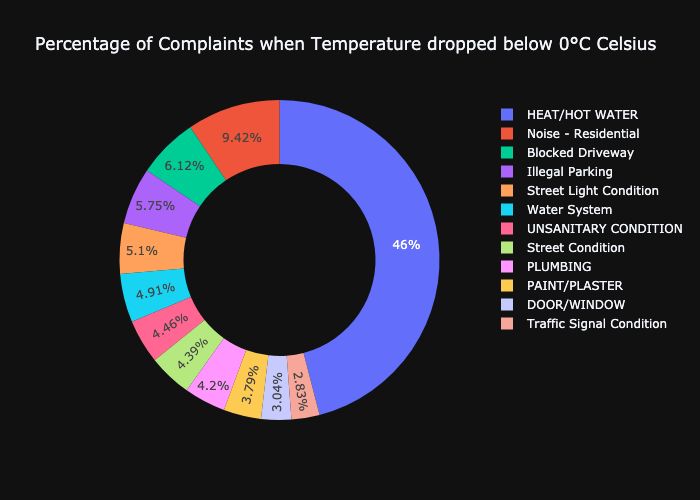

In [17]:
#-------------------------------------------------------------------------------------------
# Let us see what were the complaints related to when the temperature fell below 0 Celsius..
#-------------------------------------------------------------------------------------------
nytempfreeze = nytemperature[nytemperature['NY_Celsius']<0]
nytempfreeze = pd.merge(nytempfreeze, nycservice, left_on='datetime', right_on='DateOnly', how='inner')
nytempfreeze = nytempfreeze.groupby('complaint_type')['unique_key'].count().to_frame().reset_index()

nytempfreeze = nytempfreeze.sort_values(by='unique_key', ascending=False).nlargest(12, 'unique_key').rename(
    {'unique_key':'Count_Of_Complaints', 'complaint_type':'Type_Of_Complaint'}, axis=1)

fig = px.pie(nytempfreeze, values='Count_Of_Complaints', names='Type_Of_Complaint', hole=0.6, template='plotly_dark' ,title='Percentage of Complaints when Temperature dropped below 0°C Celsius')

pyo.iplot(fig)

fig.show('png')

In [18]:
datamerged = pd.merge(nytemperature, count, left_on='datetime', right_on='DateOnly', how='inner').drop(
    columns='DateOnly', axis=1).rename({"datetime":'Date_Of_Year'}, axis=1)

datamerged = pd.merge(datamerged, nywindspeed, left_on='Date_Of_Year', right_on='datetime', how='inner').drop('datetime',axis=1)

datamerged = pd.merge(datamerged, nyhumidity, left_on='Date_Of_Year', right_on='datetime', how='inner').drop('datetime',axis=1)

datamerged['Date_Of_Year'] = pd.to_datetime(datamerged['Date_Of_Year'])

datamerged['Day_Number'] = datamerged['Date_Of_Year'].dt.weekday

datamerged['Day_Name'] = datamerged['Day_Number'].map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',
                                                5:'Saturday',6:'Sunday'})
#datamerged.to_csv('/Users/prabavmurali/Desktop/merged.csv')
datamerged
#---------------------------------------------------------
# The merged dataset will be used for the further analysis
#---------------------------------------------------------

Date_Of_Year  NY_Celsius  Count_of_calls_each_day  NY_Wind_Speed  \
0     2016-01-01         4.0                     4315            8.0   
1     2016-01-02         2.0                     4569            7.0   
2     2016-01-03         2.0                     4806            7.0   
3     2016-01-04        -1.0                     8988            9.0   
4     2016-01-05        -8.0                    12035           10.0   
..           ...         ...                      ...            ...   
361   2016-12-27        11.0                     6249            9.0   
362   2016-12-28         4.0                     6903            5.0   
363   2016-12-29         1.0                     6327            4.0   
364   2016-12-30         2.0                     6075            7.0   
365   2016-12-31         1.0                     4227            7.0   

     NY_Humidity  Day_Number   Day_Name  
0      61.125000           4     Friday  
1      56.875000           5   Saturday  
2      62.458333           6     Sunday  
3      50.583333           0     Monday  
4      42.125000           1    Tuesday  
..           ...         ...        ...  
361    76.958333           1    Tuesday  
362    56.791667           2  Wednesday  
363    77.500000           3   Thursday  
364    64.000000           4     Friday  
365    62.958333           5   Saturday  

[366 rows x 7 columns]

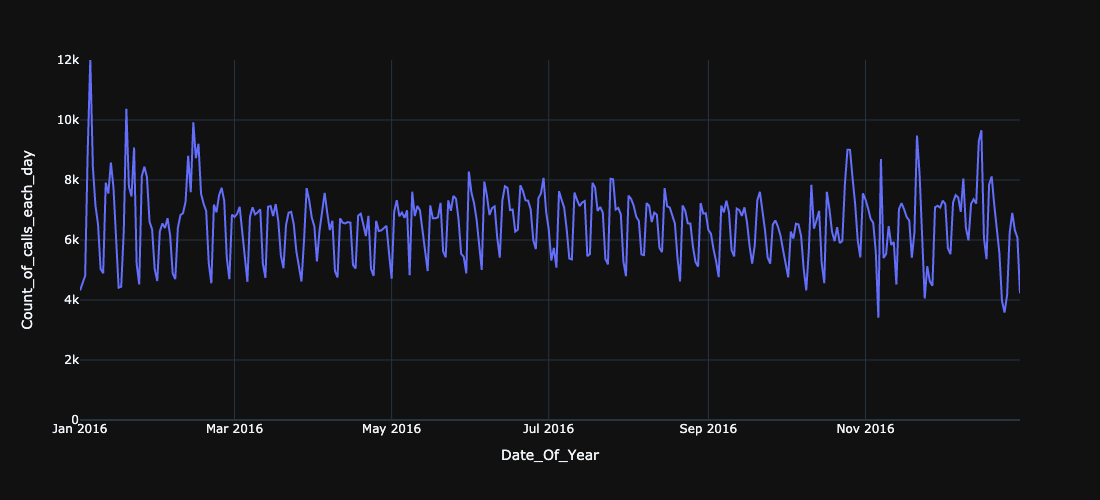

In [19]:
#---------------------------------------------
# Now let us see some important visualisations
# Count of calls everyday in the year 2016
#---------------------------------------------
calls = px.line(datamerged, x=datamerged['Date_Of_Year'], y=datamerged['Count_of_calls_each_day'], template='plotly_dark', width=1100)

calls.update_yaxes(rangemode="tozero").update_layout(yaxis_range=[0,12000])

pyo.iplot(calls)

calls.show('png')
#The below line chart depicts Count of calls received every day in 2016

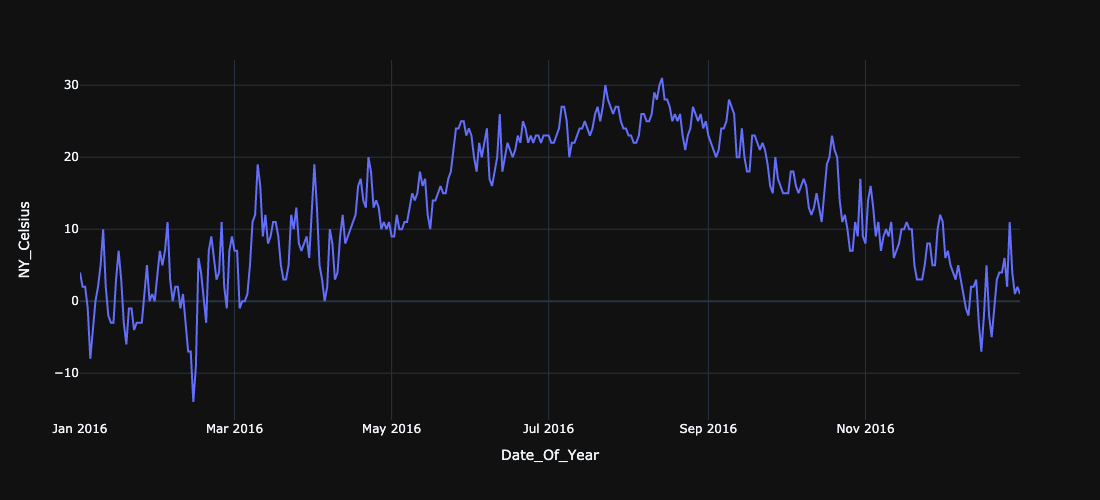

In [20]:
#--------------------------------------------
# Temperature everyday in the year 2016
#--------------------------------------------
templine = px.line(datamerged, x=datamerged['Date_Of_Year'], y=datamerged['NY_Celsius'], template='plotly_dark', width=1100)

pyo.iplot(templine)

templine.show('png')
#----------------------------------------------------------------------
#The below line chart depicts Count of calls received every day in 2016
#----------------------------------------------------------------------

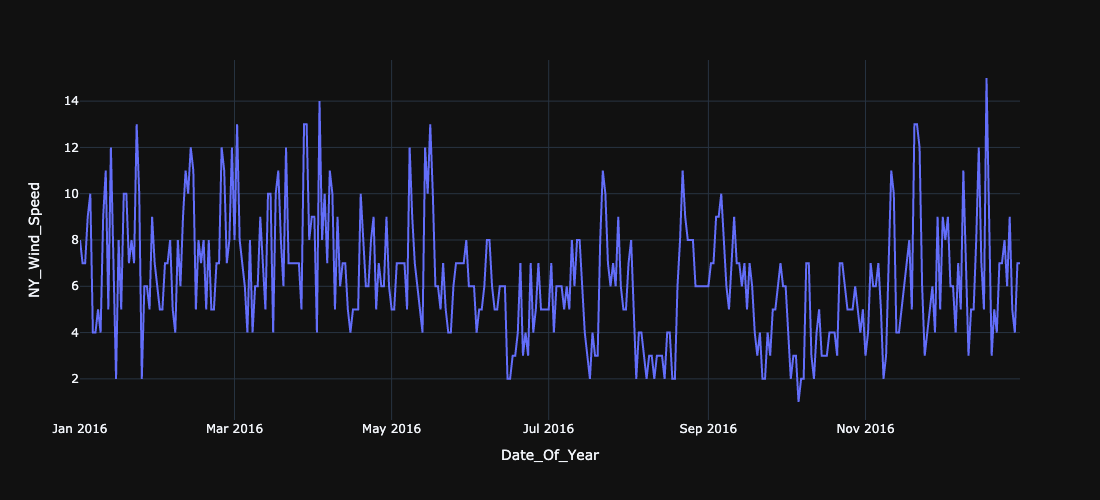

In [21]:
#--------------------------------------------
# Wind Speed everyday in the year 2016
#--------------------------------------------
windline = px.line(datamerged, x=datamerged['Date_Of_Year'], y=datamerged['NY_Wind_Speed'], template='plotly_dark', width=1100)

pyo.iplot(windline)

windline.show('png')

In [22]:
#---------------------------------------------------------------------------------
#Let us see the count of calls each month in 2016
#---------------------------------------------------------------------------------
month_dict = {'January':1,'February':2,'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}

monthcount = datamerged.groupby(datamerged['Date_Of_Year'].dt.strftime('%B'))['Count_of_calls_each_day'].sum().to_frame().sort_values(
    'Date_Of_Year', key = lambda x : x.apply (lambda x : month_dict[x])).reset_index().rename(
    {'Date_Of_Year':'Month_Of_Year','Count_of_calls_each_day':'Count_of_calls_each_month'}, axis=1)

monthcount
#---------------------------------------------------------------------------------
#January shows most calls received. Let us visualize it as a circular bar chart..
#---------------------------------------------------------------------------------

Month_Of_Year  Count_of_calls_each_month
0        January                     211474
1       February                     198427
2          March                     196968
3          April                     186106
4            May                     202393
5           June                     208524
6           July                     203504
7         August                     202213
8      September                     189380
9        October                     199363
10      November                     189023
11      December                     204013

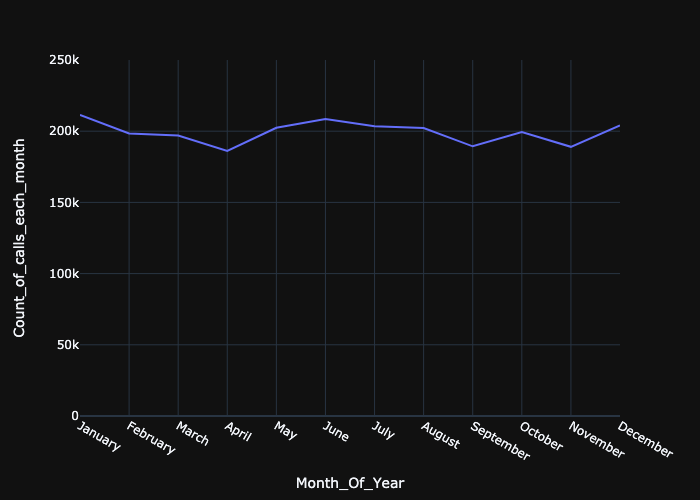

In [23]:

monthline = px.line(monthcount,monthcount['Month_Of_Year'],monthcount['Count_of_calls_each_month'],
                   template = 'plotly_dark')

monthline.update_yaxes(rangemode="tozero").update_layout(yaxis_range=[0,250000])

pyo.iplot(monthline)

monthline.show('png', size=60)
#--------------------------------------------------------------------
#The below circular bar chart shows that January had the most calls..
#--------------------------------------------------------------------

In [24]:
#--------------------------------------------------------------------------------------------------------
# Let us see which which day of the week received calls frequently
#--------------------------------------------------------------------------------------------------------
day_dict = {'Monday':0,'Tuesday':1,'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
dayname = datamerged.groupby('Day_Name')['Count_of_calls_each_day'].sum().to_frame().sort_values(
    'Day_Name', key = lambda x : x.apply (lambda x : day_dict[x])).reset_index()
dayname
#--------------------------------------------------------------------------------------------------------
# Tuesday received the most calls compared to any other day.. Let us visualise for better understanding..
#--------------------------------------------------------------------------------------------------------

Day_Name  Count_of_calls_each_day
0     Monday                   367968
1    Tuesday                   386259
2  Wednesday                   368380
3   Thursday                   358275
4     Friday                   353587
5   Saturday                   289262
6     Sunday                   267657

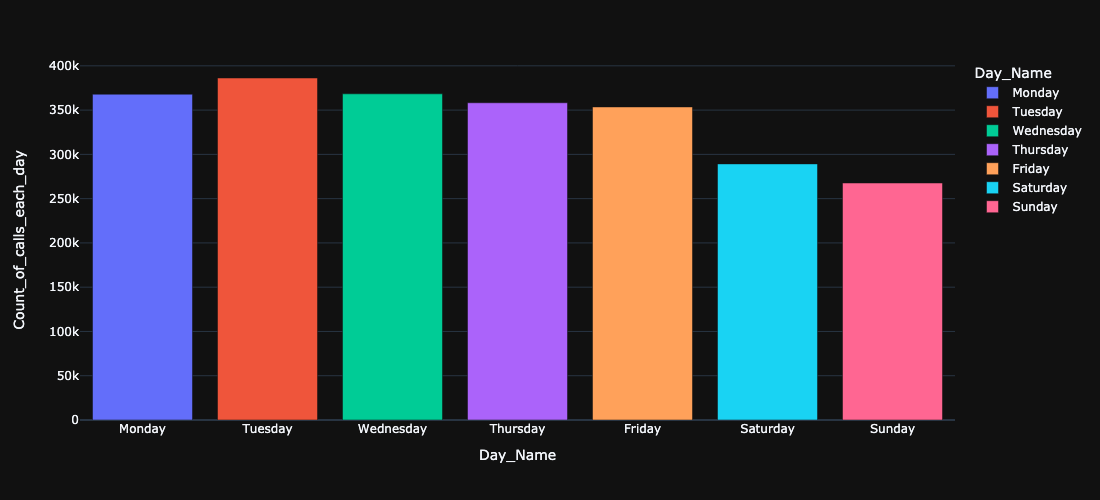

In [25]:
#--------------------------------------------------------------------------------------------------------
# From the below bar chart Tuesday received the most calls compared to any other day with not much of a 
# difference though..
#---------------------------------------------------------------------------------------------------------------------------------------
daychart = px.bar(dayname, x=dayname['Day_Name'], y=dayname['Count_of_calls_each_day'],color='Day_Name', template='plotly_dark', width=1100)

pyo.iplot(daychart)

daychart.show('png')
#---------------------------------------------------------------------------------------------------------------------------------------
#From the below bar chart, we can infer that Tuesdays had the most number of calls in 2016 
#---------------------------------------------------------------------------------------------------------------------------------------

## Statistical Tests to check Correlation and Statistical Significance

In [26]:
#--------------------------------------------------------------------------------------------------------
# Let us check the correlation score of weather parameters like temperature with Count of calls each day
#--------------------------------------------------------------------------------------------------------
tempcorrelation = datamerged['NY_Celsius'].corr(datamerged['Count_of_calls_each_day'])

windcorrelation = datamerged['NY_Wind_Speed'].corr(datamerged['Count_of_calls_each_day'])

humiditycorrelation = datamerged['NY_Humidity'].corr(datamerged['Count_of_calls_each_day'])

tempcorrelation, windcorrelation, humiditycorrelation
#-------------------------------------------------------------------------------------------------------------
# Negative Correlation indicates that call count MIGHT INCREASE when temperature or humidity
# decreases..But it is a weak correlation as the value is 0.1. Strong correlation has to be atleast 0.7 to 0.8
# ---------------------------
# Wind speed and Count of calls have a positive correlation as well, but again it is a weak correlation
#-------------------------------------------------------------------------------------------------------------

(-0.11243168940157848, 0.10195505646965816, -0.11885610029406436)

In [27]:
#----------------------------------------------------------------------
# Taking ADF Test to find whether the Count of calls Data is Stationary
#----------------------------------------------------------------------
adf_test= ADFTest(alpha = 0.05)

adf_test.should_diff(datamerged['Count_of_calls_each_day'])
#---------------------------------------------------------------------------------------------------------------
# The Count of calls data is stationary (p-val < 0.05) and there is no need of differencing which 
# is implied by the value 'False'
#---------------------------------------------------------------------------------------------------------------

(0.01, False)

In [28]:
#-------------------------------------------------------------------
# Taking ADF Test to find whether the Temperature Data is Stationary
#-------------------------------------------------------------------
adf_test= ADFTest(alpha = 0.05)

adf_test.should_diff(datamerged['NY_Celsius'])
#-------------------------------------------------------------------------------------------------
# The temperature data is non-stationary (p-val > 0.05) and there is a need for differencing which 
# is implied by the value 'True'
#-------------------------------------------------------------------------------------------------

(0.8608076163678815, True)

In [29]:
#----------------------------------------------------------
# Differencing the NY Celsius data as it is Non- Stationary
#----------------------------------------------------------
datamerged['NY_Celsius_transformed'] = datamerged['NY_Celsius'].diff().fillna(0) 
#-------------------------------
# Differenced data of NY Celsius
#-------------------------------

In [30]:
adf_test= ADFTest(alpha = 0.05)
adf_test.should_diff(datamerged['NY_Celsius_transformed'])

#-----------------------------------------------------------------------------------------------------------------------------
# Temperature Data is now Stationary (p-val < 0.05) and there is no need of differencing which is implied by the value 'False'
#-----------------------------------------------------------------------------------------------------------------------------

(0.01, False)

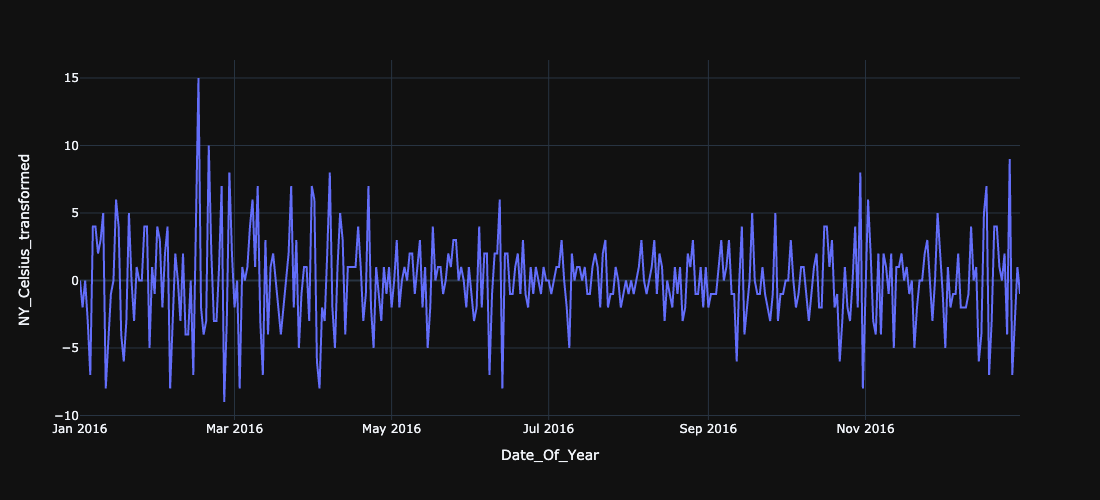

In [31]:
#-----------------------------------------------------------------------------------------------
# The Temperature is differenced (transformed to stationary) as it was previously non-stationary
#-----------------------------------------------------------------------------------------------

tempdiffline = px.line(datamerged, x=datamerged['Date_Of_Year'], y=datamerged['NY_Celsius_transformed'], template='plotly_dark', width=1100)

pyo.iplot(tempdiffline)

tempdiffline.show('png')

In [32]:
#------------------------------------------------------------------------------------------------------
# Let us check for another test to check whether the negative and positive correlation had an impact on 
# count of calls or not Granger Causality Test
#------------------------------------------------------------------------------------------------------

grangercausalitytests(datamerged[['Count_of_calls_each_day', 'NY_Celsius_transformed']], maxlag=6)

#----------------------------------------------------------------------------------------------------------------
#As the p-value is less than 0.05 (5%) at lag 6, we can reject the Null Hypothesis..
#There is a statistical relationship between two variables and impact is not by chance, but very weak correlation
#----------------------------------------------------------------------------------------------------------------


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0046  , p=0.9459  , df_denom=362, df_num=1
ssr based chi2 test:   chi2=0.0046  , p=0.9457  , df=1
likelihood ratio test: chi2=0.0046  , p=0.9457  , df=1
parameter F test:         F=0.0046  , p=0.9459  , df_denom=362, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5033  , p=0.2238  , df_denom=359, df_num=2
ssr based chi2 test:   chi2=3.0485  , p=0.2178  , df=2
likelihood ratio test: chi2=3.0359  , p=0.2192  , df=2
parameter F test:         F=1.5033  , p=0.2238  , df_denom=359, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1413  , p=0.3323  , df_denom=356, df_num=3
ssr based chi2 test:   chi2=3.4911  , p=0.3219  , df=3
likelihood ratio test: chi2=3.4744  , p=0.3241  , df=3
parameter F test:         F=1.1413  , p=0.3323  , df_denom=356, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0201  , p=0.3968  

{1: ({'ssr_ftest': (0.004608416045092235, 0.9459144077957854, 362.0, 1),
   'ssr_chi2test': (0.004646607338283607, 0.9456534699787877, 1),
   'lrtest': (0.004646577762287052, 0.9456536426711627, 1),
   'params_ftest': (0.00460841604523022, 0.9459144077948435, 362.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.5033349460634209, 0.22378386820551396, 359.0, 2),
   'ssr_chi2test': (3.048545517365377, 0.2177793774509602, 2),
   'lrtest': (3.0358503754214325, 0.21916614414932425, 2),
   'params_ftest': (1.5033349460633323, 0.22378386820554855, 359.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.1412624689411626, 0.33232867259251664, 356.0, 3),
   'ssr_chi2test': (3.4911090693172087, 0.32191707678630216, 3),
   'lrtest': (3.474428272525074, 0.3240938640939908, 3),
   'params_ftest': (1.1412624689411441, 0.33232867259251686, 356.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0

## Implementing the Time Series Forecasting to forecast next day's calls

In [33]:
#-----------------------------------------
#Converting the values to ARIMA standards
#-----------------------------------------
time = datamerged['Date_Of_Year'].value_counts()

volume = pd.DataFrame({'ds':datamerged['Date_Of_Year'], 'y':datamerged['Count_of_calls_each_day']})

volume.set_index(['ds'], inplace=True)

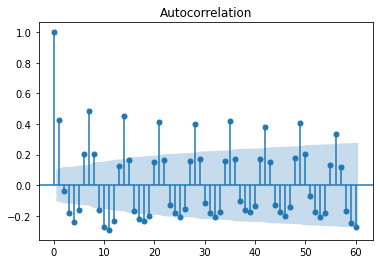

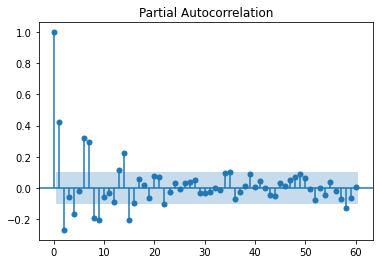

In [34]:
#--------------------------------------------------------------
#Checking for Autocorrelation and Partial Autocorrelation plots
#--------------------------------------------------------------
plot_acf(volume.y,lags=60)
plt.show()

plot_pacf(volume.y,lags=60)
plt.show()

<AxesSubplot:xlabel='ds'>

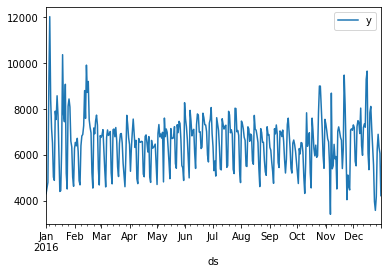

In [35]:
volume.plot()

## Implementing ARIMA model

In [36]:
#----------------------------------------------------------------------------------------------------------------
# Feature Engineering can be done to remove the outliers when feeding into the model, but when we are predicting
# the future calls, it is not a good idea to remove the outliers as there are possibilities of a spike in number
# of calls the next day. Hence, feature engineering is recommended to be avoided for this use case..
#----------------------------------------------------------------------------------------------------------------


volARIMA = volume.copy(deep=True)

#------------------------------------------------------------------------------------------------
# Performing ARIMA based analysis for Time series forecasting
# Splitting the data as Training data and test data. Train data of 290 days is fed into the model
#------------------------------------------------------------------------------------------------
arima_model = auto_arima(volARIMA.iloc[0:290], start_p=0,start_d=0,start_q=0,max_p=10,
max_d=4,max_q=10, m=20, seasonal=False,
error_action='warn',trace = True,
supress_warnings=True, stepwise = True,
random_state=20,n_fits = 100)
#---------------------------------------------------
# Using Auto Arima for searching the best parameters
#---------------------------------------------------

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5927.832, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4925.988, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5595.450, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4927.127, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4925.936, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4928.531, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4825.374, Time=0.34 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5369.751, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4827.043, Time=0.27 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4825.499, Time=0.19 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5314.520, Time=0.32 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4825.291, Time=0.38 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=4

In [37]:
#--------------------------------------------------------------------------------------------
# Let us now forecast the values based on the training data using the model's best parameters
#--------------------------------------------------------------------------------------------

futuredates = [volARIMA.y.index[-1] + DateOffset(days=x) for x in range(5)]

futureset = pd.DataFrame(index = futuredates[1:], columns = volARIMA.reset_index().ds.iloc[289:])

futureforecast = pd.concat([volARIMA, futureset]).reset_index().rename({'index':'Date'}, axis=1)

forecast = pd.DataFrame(arima_model.predict(n_periods=81,index=futureforecast.iloc[289:]))

In [38]:
#--------------------------------------------------
#Adding the column 'Forecasted values' to the data
#--------------------------------------------------
forecast.columns = ['Forecasted_Values']
forecast = forecast.set_index(futureforecast.Date.iloc[289:])

forecast.tail(n=4)
#-------------------------------------------------------------
# The ARIMA predicted value for January 1, 2017 is 5800+ calls
#-------------------------------------------------------------

Forecasted_Values
Date                         
2017-01-01        5846.611132
2017-01-02        6390.139821
2017-01-03        7030.716445
2017-01-04        7295.170856

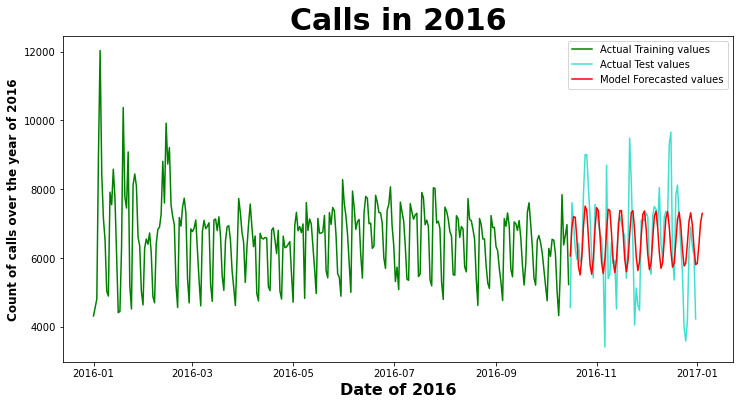

In [39]:
plt.figure(figsize=(12,6))
plt.plot(volARIMA.iloc[0:289], color='green')
plt.plot(volARIMA.iloc[289:], color='turquoise')
plt.plot(forecast, color='red')
plt.legend(['Actual Training values', 'Actual Test values', 'Model Forecasted values'])
plt.title('Calls in 2016', fontsize=30, fontweight='bold')
plt.xlabel('Date of 2016',fontsize=16, fontweight='bold')
plt.ylabel('Count of calls over the year of 2016', fontsize=12, fontweight='bold')
plt.show()

In [40]:
#-----------------------------------------------------
# Importing the evaluation metrics for the model
# Using the test set to evaluate the forecasted values
#-----------------------------------------------------

test = volARIMA.iloc[289:]

test['forecasted_values'] = forecast

print('Mean Absolute Percentage Error value for ARIMA is: ',mean_absolute_percentage_error(
    test['y'], test['forecasted_values'])*100)

print('Mean Absolute Error value for ARIMA is: ',mean_absolute_error(test['y'], test['forecasted_values']))

#------------------------------------------------------------------------------------------
# Seems the model has given good results. But we can improve the model prediction even more
# Let us try Facebook's Prophet model..
#------------------------------------------------------------------------------------------

Mean Absolute Percentage Error value for ARIMA is:  14.596892494251257
Mean Absolute Error value for ARIMA is:  861.2127476597859


## Implementing Prophet Model to forecast next day's value

In [41]:
volumeProphet = volume.copy(deep=True)

volumeProphet.shape

(366, 1)

In [42]:
#----------------------------------------------------------------------------------------------
# forecasting the values based on the training data of 280 days
#----------------------------------------------------------------------------------------------

m = Prophet()

m.fit(volumeProphet.iloc[0:280].reset_index())

future = m.make_future_dataframe(periods=90)

future.tail()

forecast = m.predict(future)

#----------------------------------------------------------------------------
# Here the parameters are ds (Time), yhat(Predicted), yhat_lower- Lower bound of Confidence Interval,
# and yhat_upper is the upper bound of the confidence interval..
#----------------------------------------------------------------------------

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


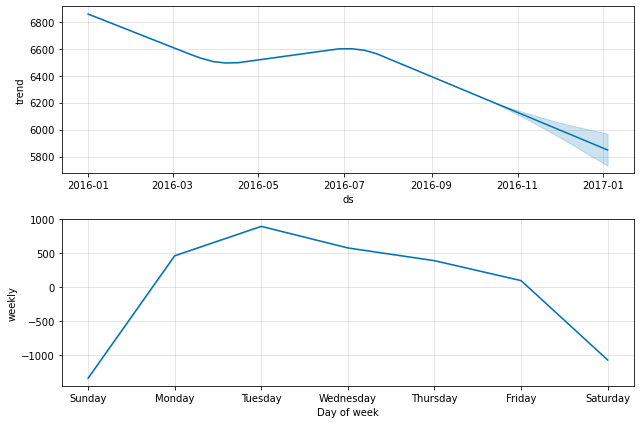

In [43]:
x = m.plot_components(forecast)
#----------------------------------------------------------------
# The below plot gives us the trend and weekly seasonality graphs
#----------------------------------------------------------------

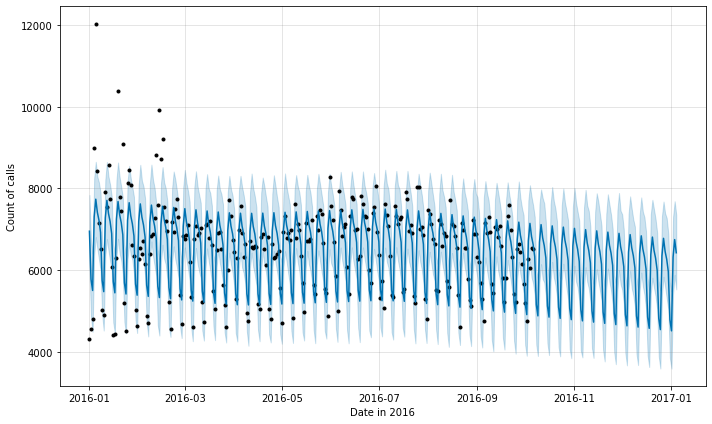

In [44]:
x = m.plot(forecast, xlabel='Date in 2016', ylabel='Count of calls')

#----------------------------------------------------------------------------------------------------------
# The black dots are the actual data points and Blue lines are the predictions with shaded regions are 
# the confidence intervals (uncertainty samples)
#----------------------------------------------------------------------------------------------------------

In [45]:
#----------------------------------------------------------------------------------------------
# Let us evaluate the model with Mean Absolute Percentage Error and Mean Absolute Error metrics
#----------------------------------------------------------------------------------------------
joined_df = volumeProphet.merge(forecast, left_on='ds', right_on='ds')

print('The Mean Absolute Percentage Error for Prophet model is',mean_absolute_percentage_error(
    joined_df.y, joined_df.yhat)*100)

print('The Mean Absolute Error for Prophet Model is',mean_absolute_error(joined_df.y, joined_df.yhat))

futureforecast = forecast[['ds','yhat','yhat_upper','yhat_lower']].tail(n=4)

futureforecast
#-------------------------------------------------------------------------------------------------------------------
# Prophet Model has performed the best among the 2 models for the 2016 data..
# The MAPE Percentage is 8.78% which is a better performing model for the given data and MAE also proves the same...
# The calls for the next day would be around 4516 which is shown below..
#-------------------------------------------------------------------------------------------------------------------

The Mean Absolute Percentage Error for Prophet model is 8.78123465718068
The Mean Absolute Error for Prophet Model is 569.2501092894228


ds         yhat   yhat_upper   yhat_lower
366 2017-01-01  4515.616942  5485.932292  3592.640845
367 2017-01-02  6319.836822  7305.241831  5419.748332
368 2017-01-03  6749.739032  7688.208316  5884.619557
369 2017-01-04  6427.052091  7357.705811  5529.715672

### I personally verified the results in the NYC Open data for the 311 Service Requests for the date 1st January, 2017 which was around 4301 calls and our forecast is 4516 calls which is a good prediction actually!

### HOORAYYY!
